In [4]:
#импортируем разное
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import matplotlib.pyplot as plt

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


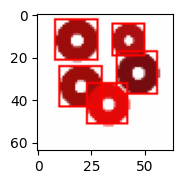

[[37 17 56 37]
 [ 8  2 28 21]
 [10 24 30 43]
 [23 32 42 51]
 [35  4 50 19]]


In [5]:
#прочитаем запись
dataset = tf.data.TFRecordDataset('bounding_box_dataset.tfrecord')


def parse_record(record):
    #нужно описать приходящий экземпляр
    #имена элементов как при записи
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'cords': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    img = tf.io.parse_tensor(parsed_record['img'], out_type=tf.float32)
    cords = tf.io.parse_tensor(parsed_record['cords'], out_type=tf.float32)
    return img, cords

#пройдемся по записи и распакуем ее
dataset = dataset.map(parse_record)

#еще раз проверим
for i, c in dataset.take(1):
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(3, 1, 1)
    i = i.numpy()
    c = c.numpy()
    c = (c+1)/2*64 #обратно из от -1...1 к 0...64
    c = c.astype(np.int16)  #для opencv
    for bb in c:
        i = cv2.rectangle(i ,(bb[0] ,bb[1] ),(bb[2], bb[3]),(1,0,0),1)
    plt.imshow(i)
    plt.show()
    print(c)

dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(32).shuffle(50)

In [56]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, Conv2DTranspose, Concatenate, LeakyReLU, Dropout

#давайте напишем нейросеть

inputs = Input((64,64,3))
x = Conv2D(32, 3, activation = 'relu', padding = 'same')(inputs)
x = Conv2D(64, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(64, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same', strides = 2)(x)
x = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(20)(x)  #4*5 = 20 у нейросети это просто выходы подряд

outputs = x

boxregressor = keras.Model(inputs, outputs)

In [57]:
def IoU_Loss(true, pred):
    #(32, 5, 4)
    t1 = true
    t2 = pred
    
    minx1, miny1, maxx1, maxy1 = tf.split(t1, 4, axis = 2)
  
    fminx, fminy, fmaxx, fmaxy = tf.split(t2, 4, axis = 2)
    minx2 = tf.minimum(fminx, fmaxx)
    miny2 = tf.minimum(fminy, fmaxy)
    maxx2 = tf.maximum(fminx, fmaxx)
    maxy2 = tf.maximum(fminy, fmaxy)
    
    
    intersection = 0.0 
    
    #найдем пересечение каждого из предсказанных с каждым из реальных
    #сложим все вместе
    for i1 in range(5):
        for i2 in range(5):
            x_overlap = tf.maximum(0.0, tf.minimum(maxx1[:,i1], maxx2[:,i2]) - tf.maximum(minx1[:,i1], minx2[:,i2]))
            y_overlap = tf.maximum(0.0, tf.minimum(maxy1[:,i1], maxy2[:,i2]) - tf.maximum(miny1[:,i1], miny2[:,i2]))
            intersection += x_overlap*y_overlap
            
    #с несколькими обьектами сложнее. Мы не можем просто найди обьединение трех и более прямоугольников по координатам
    #пойдем на некоторые хитрости.
    #не будем считасть обьединение и сравнивать его с пересечение как в IoU
    #а будем стремится сделать площади всех элементов такими-же, как у реальных рамок 
    #просто среднеквадратичной ошибкой
            
    beta1 = 0.0
    for i1 in range(5):
        for i2 in range(5):
            x_overlap = tf.maximum(0.0, tf.minimum(maxx1[:,i1], maxx1[:,i2]) - tf.maximum(minx1[:,i1], minx1[:,i2]))
            y_overlap = tf.maximum(0.0, tf.minimum(maxy1[:,i1], maxy1[:,i2]) - tf.maximum(miny1[:,i1], miny1[:,i2]))
            beta1 += x_overlap*y_overlap
            
    beta2 = 0.0
    for i1 in range(5):
        for i2 in range(5):
            x_overlap = tf.maximum(0.0, tf.minimum(maxx2[:,i1], maxx2[:,i2]) - tf.maximum(minx2[:,i1], minx2[:,i2]))
            y_overlap = tf.maximum(0.0, tf.minimum(maxy2[:,i1], maxy2[:,i2]) - tf.maximum(miny2[:,i1], miny2[:,i2]))
            beta2 += x_overlap*y_overlap
            
    
    loss = (beta1 - beta2)**2 - intersection
    
    return loss

    


In [58]:
class Model(tf.keras.Model):
    def __init__(self, nn_box):
        super(Model, self).__init__()
        self.nn_box = nn_box
        
        self.box_optimizer = tf.keras.optimizers.Adam(5e-4, beta_1=0.5)
        
    @tf.function
    def training_step(self, x, true_boxes):
        
        with tf.GradientTape() as tape_box:
            
            pred = self.nn_box(x, training=True)
            pred = tf.reshape(pred, [-1, 5, 4])

            loss = IoU_Loss(true_boxes, pred)   
      #      print('test', tf.reduce_mean(IoU_Loss(true_boxes, true_boxes) ))

        # Backpropagation.
        grads = tape_box.gradient(loss, self.nn_box.trainable_variables)
        self.box_optimizer.apply_gradients(zip(grads, self.nn_box.trainable_variables))

        return loss
    
model = Model(boxregressor)

In [9]:
for i, c in dataset.take(1):
    print(tf.reduce_mean(model.training_step(i, c)))

tf.Tensor(1.9794328, shape=(), dtype=float32)


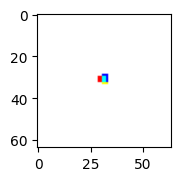

In [59]:
#проверка работы
def testing():
    for ii, cc in dataset.take(1):
        #обрабатывем целый батч, используем только пять элементов
        pred = model.nn_box(ii)
        plt.figure(figsize=(10, 6))
        
        for num in range(5):
            i = ii[num]
            
            pred = tf.reshape(pred, [-1, 5, 4])
            c = pred[num]

            ax = plt.subplot(1, 5, num+1)
            #переход в numpy для работы в opencv
            i = i.numpy()
            c = c.numpy()
            c = (c+1)/2*64 #обратно из от -1...1 к 0...64
            c = c.astype(np.int16)  #для opencv
            for bb in c:
                i = cv2.rectangle(i ,(bb[0] ,bb[1] ),(bb[2], bb[3]),(0,1,0),1)
            plt.imshow(i)
            
        plt.show()
       # print(c)
        
testing()

154


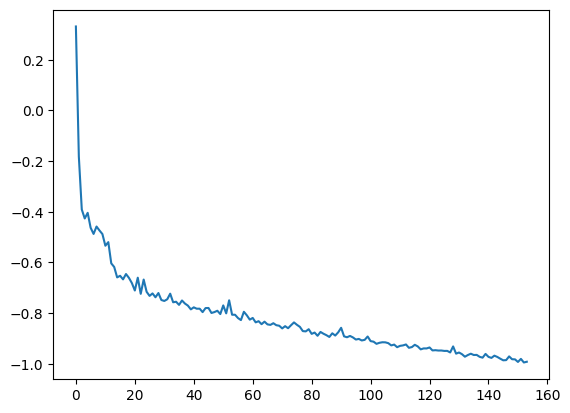

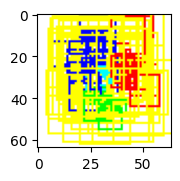

KeyboardInterrupt: 

In [63]:
from IPython.display import clear_output
hist = np.array(np.empty([0]))
epochs = 1000
for epoch in range(1, epochs + 1):
    loss = 0
    lc = 0
    for step, (i, c) in enumerate(dataset):
        loss+=tf.reduce_mean(model.training_step(i,c))
        lc+=1
    clear_output(wait=True)
    print(epoch)
    hist = np.append(hist, loss/lc)
    plt.plot(np.arange(0,len(hist)), hist)
    plt.show()
    testing()

In [54]:
#сохранить
model.nn_box.save('bounding_box_for_many_objects.h5')

In [55]:
#загрузить веса
model.nn_box.load_weights('bounding_box_for_many_objects.h5')

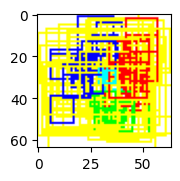

In [64]:
#проверка работы
def testing2():
    for ii, cc in dataset.take(1):
        #обрабатывем целый батч, используем только пять элементов
        pred = model.nn_box(ii)
        plt.figure(figsize=(10, 6))
        screen = np.full((64,64,3), 1, dtype=np.float32)
        
        for num in range(ii.shape[0]):
            i = ii[num]
            
            pred = tf.reshape(pred, [-1, 5, 4])
            c = pred[num]

            ax = plt.subplot(1, 5, 1)
            #переход в numpy для работы в opencv
            i = i.numpy()
            c = c.numpy()
            c = (c+1)/2*64 #обратно из от -1...1 к 0...64
            c = c.astype(np.int16)  #для opencv
            for l, bb in enumerate(c):
                if l == 0:
                    screen = cv2.rectangle(screen ,(bb[0] ,bb[1] ),(bb[2], bb[3]),(0,1,0),1)
                if l == 1:
                    screen = cv2.rectangle(screen ,(bb[0] ,bb[1] ),(bb[2], bb[3]),(1,0,0),1)
                if l == 2:
                    screen = cv2.rectangle(screen ,(bb[0] ,bb[1] ),(bb[2], bb[3]),(0,0,1),1)
                if l == 3:
                    screen = cv2.rectangle(screen ,(bb[0] ,bb[1] ),(bb[2], bb[3]),(1,1,0),1)
                if l == 4:
                    screen = cv2.rectangle(screen ,(bb[0] ,bb[1] ),(bb[2], bb[3]),(0,1,1),1)
            plt.imshow(screen)
            
        plt.show()
       # print(c)
        
testing2()